<a href="https://colab.research.google.com/github/Tharindu1527/tharindu1527/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#----------01.set up the pretrain model----------.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-02-26 06:35:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 142.251.107.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   179MB/s    in 0.5s    

2024-02-26 06:35:59 (179 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#in this moment if we use InseptionV3 model for convolute the layers that's awsome because if we use we don't want to add any Conv2D or MaxPooling layers mannulay because InseptionV3 model aso add those layers by itself

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

#set weight file you downloaded in to a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#initialize the base model
#set the input shape and remove dense layer
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights = None)

#load the pre trained weight you downloaded.
pre_trained_model.load_weights(local_weights_file)

#freeze the weight of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False


In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [11]:
#choose 'mixed7' as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [12]:
#add dense layers for our classifier
from tensorflow.keras.optimizers import RMSprop#RMSprop use for fast training rate
from tensorflow.keras import Model

#flattten the out put layer to 1 dimension
x = layers.Flatten()(last_output)

#add fully connected layer with 1024 hidden units and activating relu
x = layers.Dense(1024, activation='relu')(x)

#add the dropout rate of 0.2-----actually that mean when we use large nural network it has an so mmany relationships with
#each layers when network is so big that caused overfitting that's why we have to reduse that relationships with layers
#that's why we use dropout function that use for remove unnecessary relationships with layers
x = layers.Dropout(0.2)(x)

#add final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

#Append the dense network to the base model
model = Model(pre_trained_model.input,x)

#print the model summery
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [13]:
#set the training parameter
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#----------02.prepare the dataset--------

In [14]:
#download dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-02-26 07:08:53--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 172.217.193.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  90.1MB/s    in 0.7s    

2024-02-26 07:08:53 (90.1 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [16]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#extract the achive
zip_ref=zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")#after extract then files goes to 'tmp' named file
zip_ref.close()#when finish extraction process then close zip

#Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

#directory with training cat
train_cat_dir= os.path.join(train_dir,'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


#data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range = 40,
                                   width_shift_range = 0.02,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#special point---validation data shouldn't be argumented because those are not trained
test_datagen = ImageDataGenerator(rescale=1/255.0)

#fllow training images in bathces of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#train the model

In [17]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2)

Epoch 1/20
100/100 - 193s - loss: 0.3302 - accuracy: 0.8715 - val_loss: 0.1102 - val_accuracy: 0.9580 - 193s/epoch - 2s/step
Epoch 2/20
100/100 - 183s - loss: 0.1780 - accuracy: 0.9295 - val_loss: 0.0959 - val_accuracy: 0.9620 - 183s/epoch - 2s/step
Epoch 3/20
100/100 - 186s - loss: 0.1474 - accuracy: 0.9380 - val_loss: 0.1281 - val_accuracy: 0.9550 - 186s/epoch - 2s/step
Epoch 4/20
100/100 - 186s - loss: 0.1442 - accuracy: 0.9390 - val_loss: 0.1000 - val_accuracy: 0.9640 - 186s/epoch - 2s/step
Epoch 5/20
100/100 - 186s - loss: 0.1378 - accuracy: 0.9495 - val_loss: 0.0784 - val_accuracy: 0.9650 - 186s/epoch - 2s/step
Epoch 6/20
100/100 - 185s - loss: 0.0967 - accuracy: 0.9655 - val_loss: 0.1727 - val_accuracy: 0.9460 - 185s/epoch - 2s/step
Epoch 7/20
100/100 - 185s - loss: 0.1423 - accuracy: 0.9490 - val_loss: 0.1148 - val_accuracy: 0.9570 - 185s/epoch - 2s/step
Epoch 8/20
100/100 - 184s - loss: 0.1204 - accuracy: 0.9560 - val_loss: 0.0935 - val_accuracy: 0.9640 - 184s/epoch - 2s/step


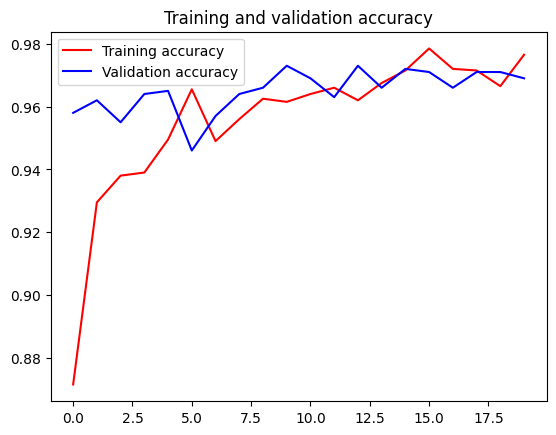

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()